<a href="https://colab.research.google.com/github/2303a51019/NLP/blob/main/NLP_LAB_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Exploration

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Positive: 12500
Negative: 12500


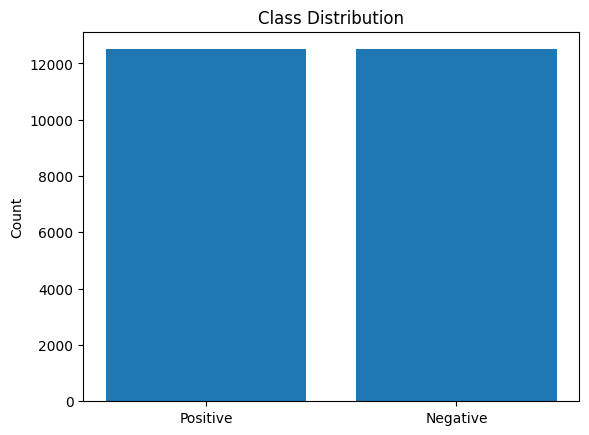

In [1]:
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load IMDb dataset
dataset = load_dataset("imdb")

# Count labels
train_labels = dataset["train"]["label"]
pos = sum(1 for x in train_labels if x == 1)
neg = sum(1 for x in train_labels if x == 0)

print("Positive:", pos)
print("Negative:", neg)

# Bar chart
plt.bar(["Positive", "Negative"], [pos, neg])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


Bi-LSTM Sentiment Classifier

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset

# Load dataset
data = load_dataset("imdb")
train_texts = data["train"]["text"]
train_labels = data["train"]["label"]
test_texts = data["test"]["text"]
test_labels = data["test"]["label"]

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=200)

y_train = tf.convert_to_tensor(train_labels)
y_test = tf.convert_to_tensor(test_labels)

# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 746ms/step - accuracy: 0.6928 - loss: 0.5658 - val_accuracy: 0.7108 - val_loss: 0.6706
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9173 - loss: 0.2163 - val_accuracy: 0.6794 - val_loss: 0.7443
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9569 - loss: 0.1247 - val_accuracy: 0.8510 - val_loss: 0.4137
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8285 - loss: 0.4228
Test Accuracy: 0.8458399772644043


BERT Fine-tuning

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset

dataset = load_dataset("imdb")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

args = TrainingArguments(
    "bert-imdb",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    report_to="none" # Disable wandb logging
)

trainer = Trainer(model=model, args=args,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["test"])

trainer.train()

result = trainer.evaluate()
print(result)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 